In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from Tools.config_helpers import loadConfig, make_small
from klepto.archives import dir_archive

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.trilep_analysis import trilep_analysis
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [3]:
# an equivalent code can be run with ipython -i trilep_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small

overwrite = True
year      = 2018
small     = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'trilep_analysis_2tight_1veto'
if small: cacheName += '_small'

cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

fileset = {
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'diboson': fileset_2018['diboson'],
    'ttbar': fileset_2018['top2l'],
    'DY': fileset_2018['DY'],
    'MuonEG': fileset_2018['MuonEG'],
    'DoubleMuon': fileset_2018['DoubleMuon'],
    'EGamma': fileset_2018['EGamma'],
}

fileset = make_small(fileset, small, n_max=1)  # run over just one file each if small is set to true

# add all processes to output so that the cutflow doesn't fail
add_processes_to_output(fileset, desired_output)

# add some histograms that we defined in the processor
# everything else is taken the default_accumulators.py
from processor.default_accumulators import mass_axis, dataset_axis
desired_output.update({
    "dilep_mass": hist.Hist("Counts", dataset_axis, mass_axis),
})

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        trilep_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Preprocessing:   0%|          | 0/1057 [00:00<?, ?file/s]

Processing:   0%|          | 0/1059 [00:00<?, ?chunk/s]

/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/env

In [4]:
# we can just take the process list from the fileset to avoid any confusions
processes = list(fileset.keys())

processes.remove('topW_EFT_cp8')
processes.remove('topW_EFT_mix')

# the following list is directly taken from Tools/selection.py
lines = ['entry']
lines += [
            'filter',
            'lepveto',
            'trilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'offZ',
            'MET>50',
            'N_jet>2',
            'N_central>1',
            'N_btag>0',
            'N_fwd>0',
        ]

from Tools.helpers import getCutFlowTable
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,MuonEG,DoubleMuon,EGamma,S/B
entry,33.99 +/- 0.09,546.8 +/- 3.5,2267.0 +/- 4.0,612.5 +/- 1.4,34360.0 +/- 60.0,130300.0 +/- 100.0,385400.0 +/- 1200.0,543500.0 +/- 700.0,1016000.0 +/- 1000.0,300700.0 +/- 500.0,0.0000
filter,33.96 +/- 0.09,546.2 +/- 3.5,2264.0 +/- 4.0,611.9 +/- 1.4,34340.0 +/- 60.0,130200.0 +/- 100.0,385300.0 +/- 1200.0,543300.0 +/- 700.0,1016000.0 +/- 1000.0,300600.0 +/- 500.0,0.0000
lepveto,30.22 +/- 0.09,466.7 +/- 3.1,1919.0 +/- 3.0,493.3 +/- 1.3,33290.0 +/- 50.0,95340.0 +/- 120.0,335000.0 +/- 1200.0,376400.0 +/- 600.0,632000.0 +/- 800.0,255600.0 +/- 500.0,0.0000
trilep,13.13 +/- 0.06,196.2 +/- 1.9,816.4 +/- 2.2,194.8 +/- 0.8,13000.0 +/- 30.0,38260.0 +/- 60.0,160400.0 +/- 800.0,68090.0 +/- 260.0,172200.0 +/- 400.0,56630.0 +/- 240.0,0.0000
p_T(lep0)>25,13.06 +/- 0.06,195.1 +/- 1.9,813.7 +/- 2.2,192.6 +/- 0.8,12730.0 +/- 30.0,37850.0 +/- 60.0,158200.0 +/- 800.0,66830.0 +/- 260.0,166900.0 +/- 400.0,56430.0 +/- 240.0,0.0000
p_T(lep1)>20,12.58 +/- 0.06,188.2 +/- 1.8,788.4 +/- 2.2,181.6 +/- 0.8,12030.0 +/- 30.0,35510.0 +/- 60.0,150300.0 +/- 800.0,63300.0 +/- 250.0,156100.0 +/- 400.0,54090.0 +/- 230.0,0.0000
trigger,12.18 +/- 0.06,181.7 +/- 1.8,768.8 +/- 2.2,175.4 +/- 0.8,11650.0 +/- 30.0,34270.0 +/- 60.0,145300.0 +/- 800.0,18060.0 +/- 130.0,145500.0 +/- 400.0,33520.0 +/- 180.0,0.0000
offZ,10.92 +/- 0.05,161.5 +/- 1.7,191.2 +/- 1.1,153.1 +/- 0.7,2863.0 +/- 16.0,29720.0 +/- 50.0,27340.0 +/- 330.0,14800.0 +/- 120.0,38760.0 +/- 200.0,8675.0 +/- 93.0,0.0001
MET>50,9.05 +/- 0.048,129.8 +/- 1.5,133.0 +/- 0.9,120.6 +/- 0.6,1439.0 +/- 12.0,20620.0 +/- 50.0,3170.0 +/- 107.0,9756.0 +/- 99.0,13020.0 +/- 110.0,3025.0 +/- 55.0,0.0002
N_jet>2,8.598 +/- 0.047,106.6 +/- 1.4,118.7 +/- 0.8,108.4 +/- 0.6,410.9 +/- 6.3,12320.0 +/- 30.0,599.8 +/- 46.1,5658.0 +/- 75.0,5900.0 +/- 77.0,1436.0 +/- 38.0,0.0003


In [5]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,MuonEG,DoubleMuon,EGamma
entry,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
filter,0.9991,0.9991,0.9990,0.9989,0.9996,0.9997,0.9998,0.9996,0.9997,0.9995
lepveto,0.8898,0.8543,0.8476,0.8062,0.9694,0.7321,0.8694,0.6928,0.6222,0.8504
trilep,0.4347,0.4204,0.4254,0.3949,0.3904,0.4013,0.4789,0.1809,0.2724,0.2216
p_T(lep0)>25,0.9942,0.9943,0.9967,0.9890,0.9798,0.9895,0.9859,0.9815,0.9695,0.9964
p_T(lep1)>20,0.9636,0.9646,0.9689,0.9429,0.9444,0.9381,0.9505,0.9471,0.9353,0.9586
trigger,0.9681,0.9655,0.9752,0.9656,0.9689,0.9650,0.9663,0.2853,0.9321,0.6198
offZ,0.8962,0.8890,0.2487,0.8731,0.2457,0.8672,0.1882,0.8196,0.2664,0.2588
MET>50,0.8290,0.8037,0.6957,0.7878,0.5025,0.6939,0.1160,0.6592,0.3358,0.3487
N_jet>2,0.9501,0.8212,0.8922,0.8981,0.2856,0.5973,0.1892,0.5800,0.4533,0.4747


In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 200)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v3': 'top-W scat.',
    'topW_EFT_cp8': 'EFT, cp8',
    'topW_EFT_mix': 'EFT mix',
    'TTZ': r'$t\bar{t}Z$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'ttbar': r'$t\bar{t}$',
    'DY': 'Drell-Yan',
}

my_colors = {
    'topW_v3': '#FF595E',
    'topW_EFT_cp8': '#000000',
    'topW_EFT_mix': '#0F7173',
    'TTZ': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'ttbar': '#1982C4',
    'DY': '#6A4C93',}

Data: 0 MC: 8082.9


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


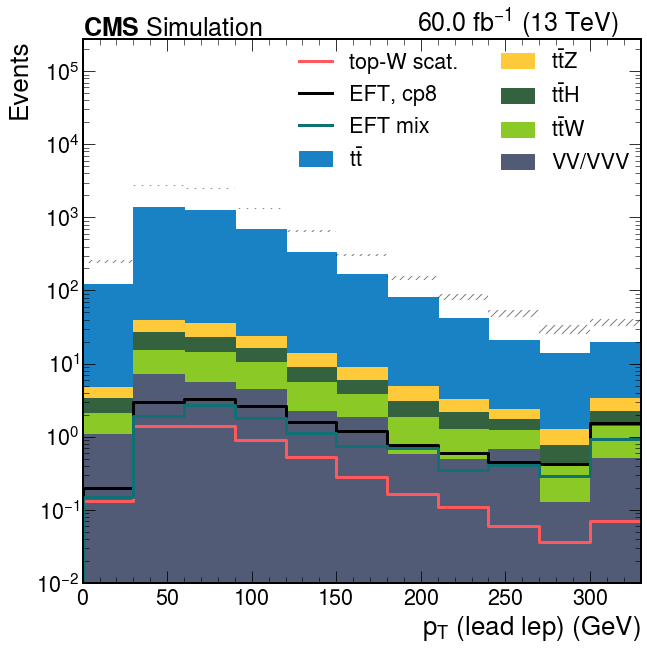

In [7]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=['topW_v3', 'topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 8087.99


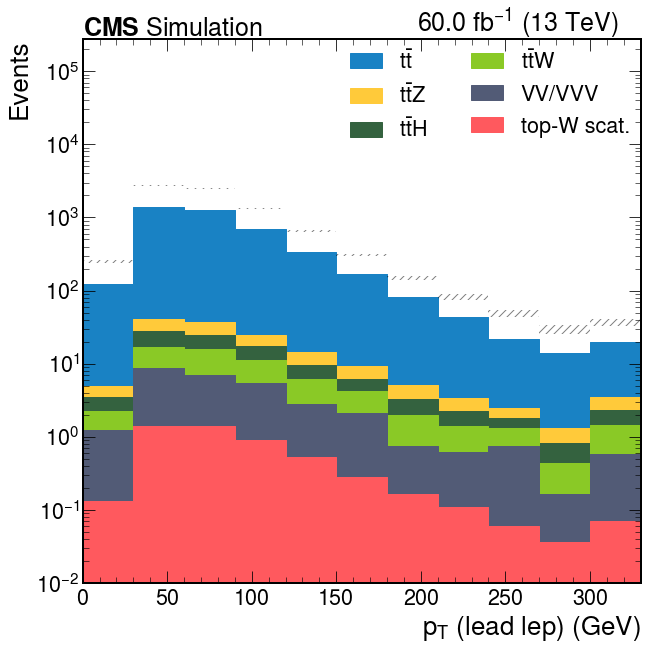

In [8]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 8087.99


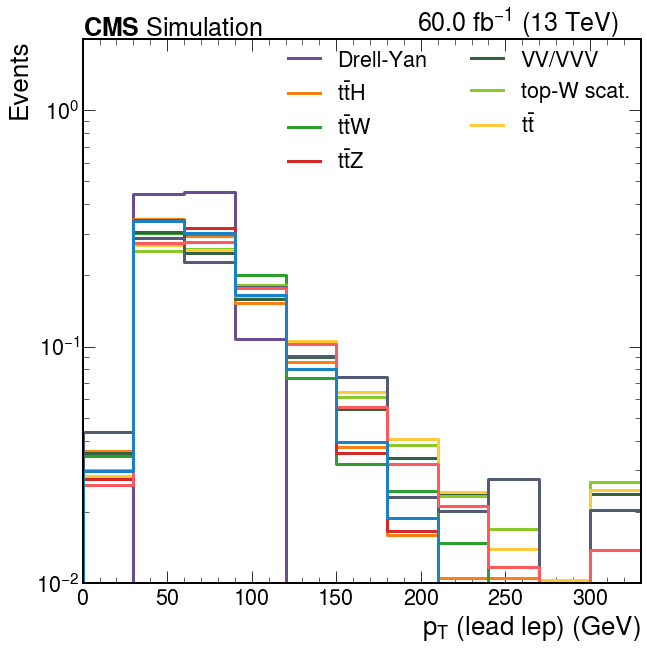

In [9]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 3960.89


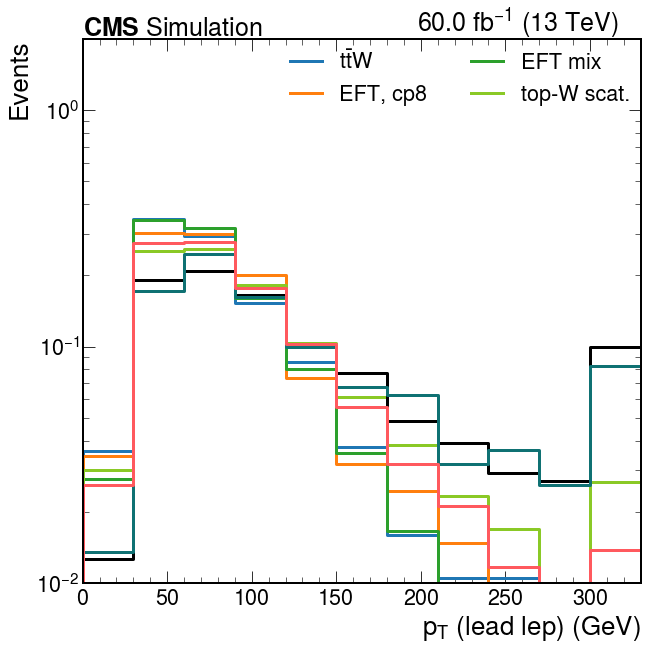

In [10]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['DY', 'ttbar', 'TTZ', 'TTH', 'diboson'],
        )

Data: 0 MC: 6110.3
Data: 0 MC: 6110.3


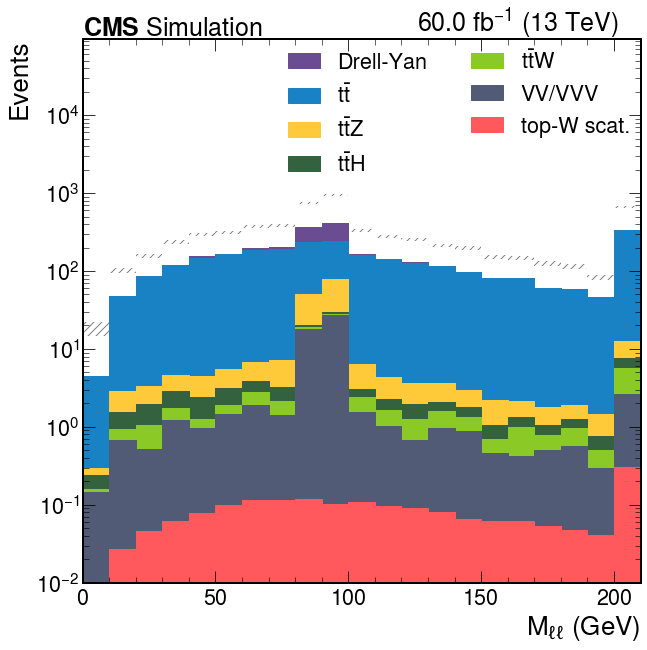

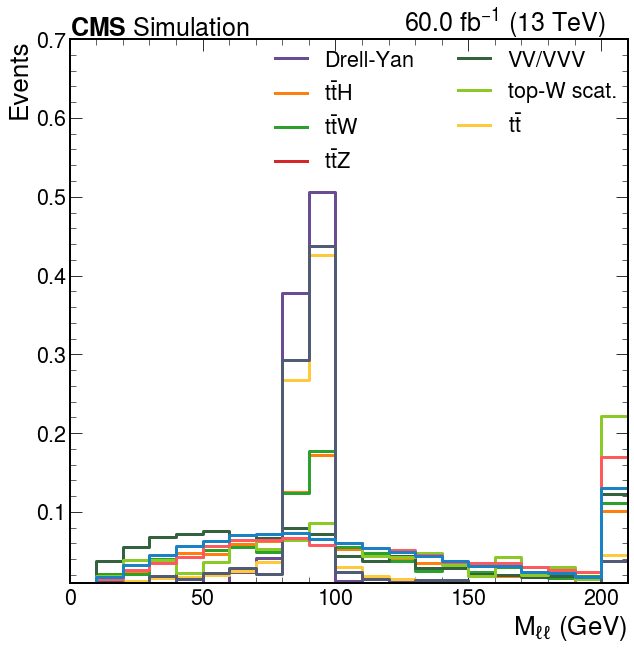

In [11]:
makePlot(output, 'dilep_mass', 'mass',
         bins=mass_bins, log=True, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson',  'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )
makePlot(output, 'dilep_mass', 'mass',
         shape=True,
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         ymax=0.7,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Here are the graphs:

Data: 3896.0 MC: 4191.99


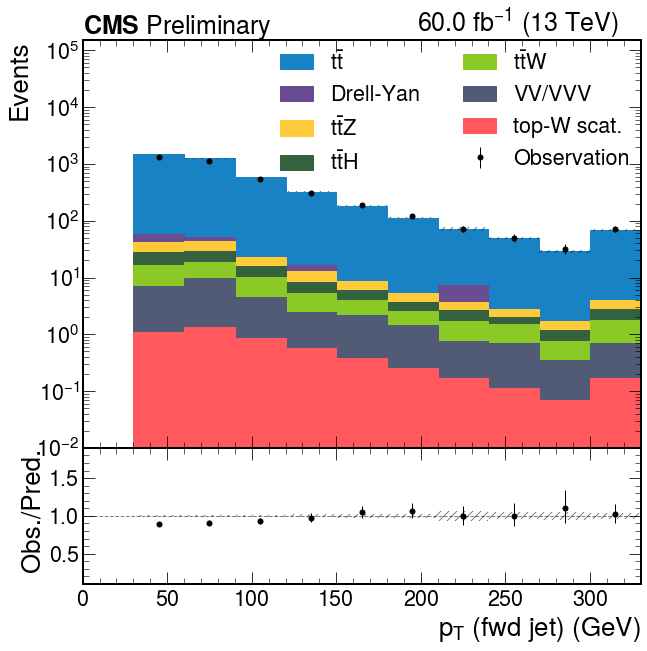

In [12]:
makePlot(output, 'fwd_jet', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (fwd jet) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3896.0 MC: 4191.99


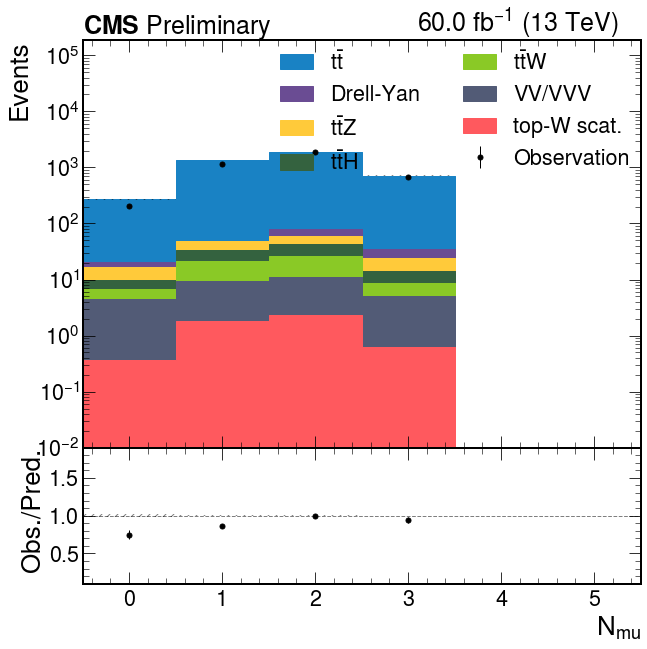

In [13]:
makePlot(output, 'N_mu', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{mu}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3896.0 MC: 4191.99


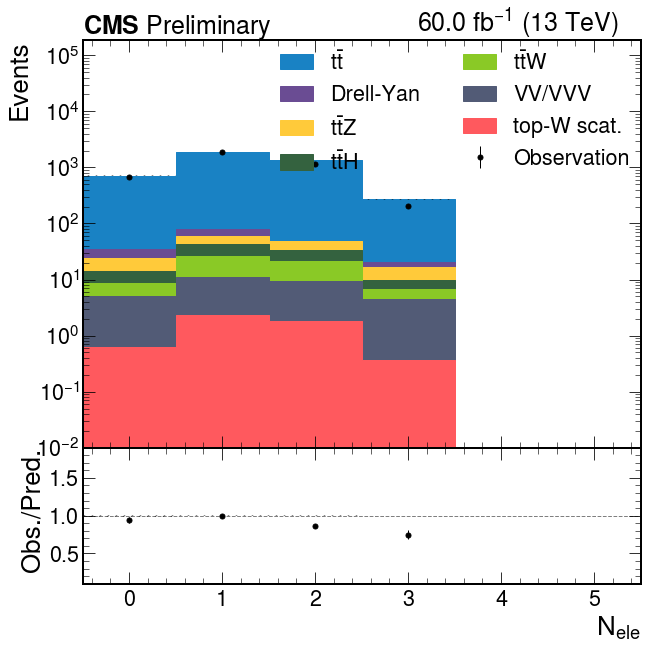

In [14]:
makePlot(output, 'N_ele', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{ele}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 3896.0 MC: 4191.99


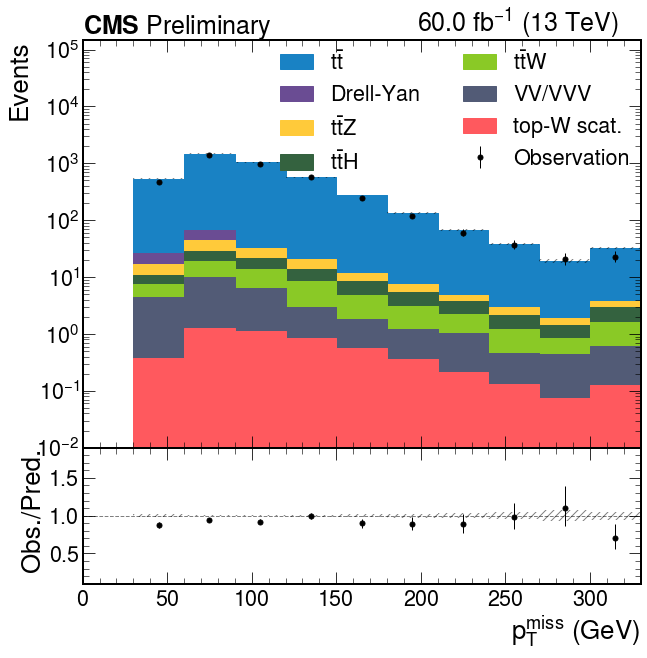

In [15]:
makePlot(output, 'MET', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}^{miss}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ','DY', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )